# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.166855,False,-3.280440
1,0.218907,False,0.889082
2,0.734806,False,1.657342
3,-0.917507,False,-2.436045
4,-0.928110,True,3.326863
...,...,...,...
995,0.020738,False,-0.739023
996,-0.399244,True,3.805734
997,-0.514277,True,3.944842
998,0.101339,False,1.157327


<AxesSubplot:xlabel='v0'>

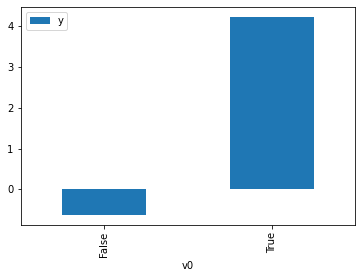

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

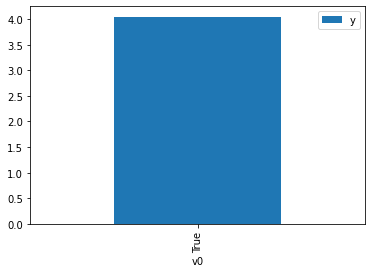

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.323771,False,-3.482634,0.575859,1.736537
1,-0.731096,False,-0.710747,0.543950,1.838404
2,-0.452757,False,-1.103364,0.528822,1.890994
3,0.490579,False,2.124327,0.477324,2.095015
4,-0.612867,False,-0.971029,0.537533,1.860352
...,...,...,...,...,...
995,0.921740,False,3.194826,0.453880,2.203228
996,0.267991,False,1.387931,0.489472,2.043016
997,-2.498562,False,-7.136165,0.637047,1.569742
998,-0.618318,False,0.670679,0.537829,1.859328


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.658777,True,-1.187812,0.406364,2.460851
1,-0.187566,True,5.760379,0.485640,2.059137
2,-0.181223,True,2.709213,0.485987,2.057670
3,0.250209,True,5.539353,0.509556,1.962491
4,0.640482,True,7.162167,0.530844,1.883793
...,...,...,...,...,...
995,0.918133,True,6.682376,0.545925,1.831753
996,-0.261398,True,3.772434,0.481610,2.076368
997,1.147443,True,8.607756,0.558318,1.791093
998,-0.519152,True,4.039850,0.467563,2.138749


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              9114.
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:39:18   Log-Likelihood:                         -1411.0
No. Observations:                1000   AIC:                                      2826.
Df Residuals:                     998   BIC:                                      2836.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7529      0.030     92.547      0.000       2.695       2.811
x2             5.0053      0.046    109.391      0.000       4.915       5.095
==============================================================================
Omnibus:                        0.119   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.942   Jarque-Bera (JB):                0.072
Skew:                           0.017   Prob(JB):                        0.965
Kurtosis:                       3.023   Cond. No.                         1.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""